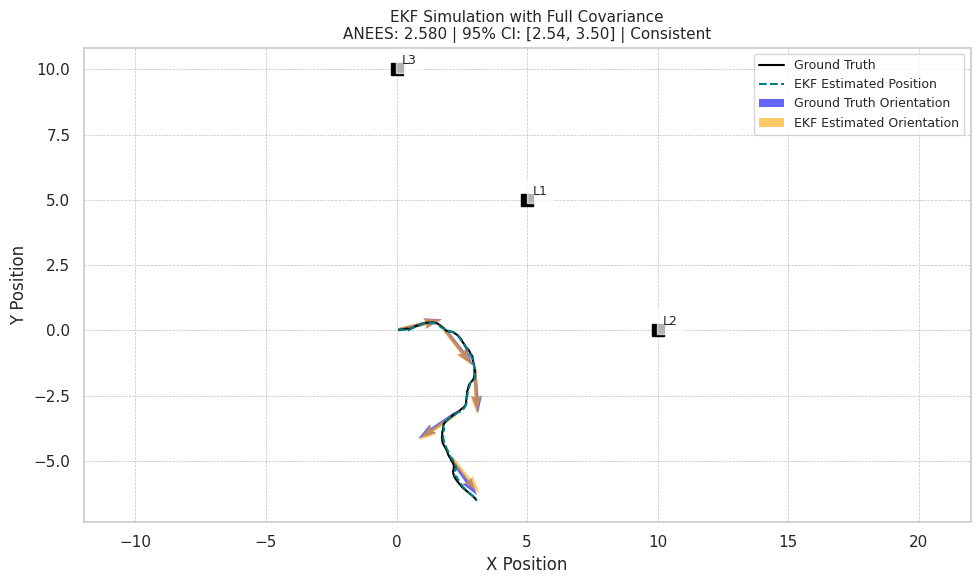

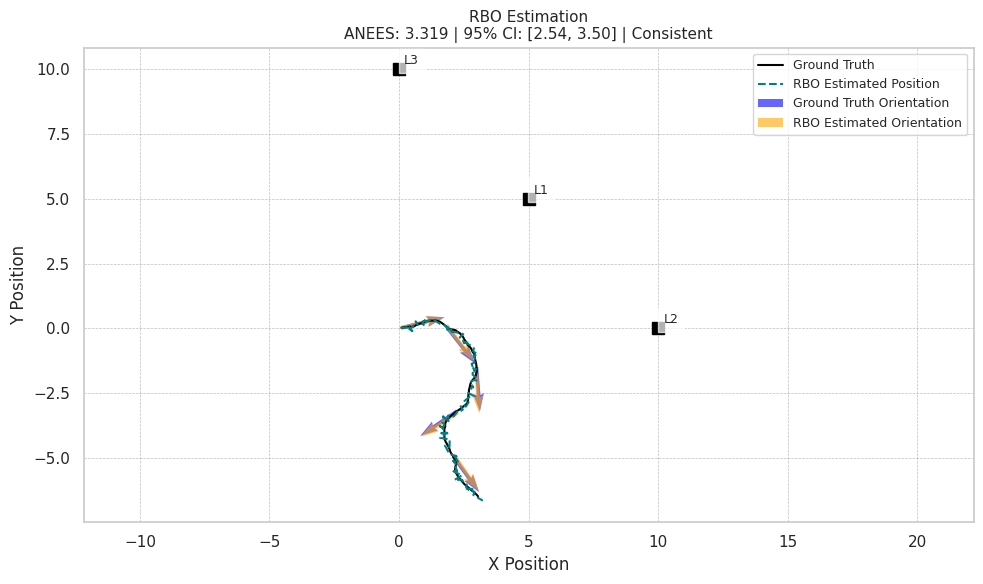

In [4]:
###########################################################################
# Full EKF simulation (prediction + correction)
###########################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2

# Plotting style
sns.set_context("notebook")
sns.set_style("whitegrid")

# Configuration
config = {
    'wheel_base': 0.5,
    'wheel_diameter': 0.1,
    'time_steps': 100,
    'landmarks': [(5, 5), (10, 0), (0, 10)],
    'motion_noise': {'DL': 0.01, 'DR': 0.01},
    'sensor_noise': {'Drho': 0.1, 'Dphi': 0.05},
    'seed_motion': 24,
    'seed_sensor': 123,
    'initial_pose': (0.0, 0.0, 0.0)
}

rng_motion = np.random.default_rng(config['seed_motion'])
rng_sensor = np.random.default_rng(config['seed_sensor'])

def motion_model(x, u, b):
    dl, dr = u
    d = (dl + dr) / 2.0
    theta = x[2]
    theta_new = theta + (dr - dl) / b
    theta_new = np.arctan2(np.sin(theta_new), np.cos(theta_new))
    x_new = x[0] + d * np.cos(theta_new)
    y_new = x[1] + d * np.sin(theta_new)
    return np.array([x_new, y_new, theta_new])

def jacobian_F(theta, dl, dr, b):
    d = (dl + dr) / 2.0
    dtheta = (dr - dl) / b
    theta_new = theta + dtheta
    Fx = np.array([
        [1, 0, -d * np.sin(theta_new)],
        [0, 1,  d * np.cos(theta_new)],
        [0, 0, 1]
    ])
    return Fx

pose_actual = np.array(config['initial_pose'])
pose_est = np.array(config['initial_pose'])
P = np.eye(3) * 0.01
data_log = []

for t in range(config['time_steps']):
    turn_bias = rng_motion.normal(0, 0.05)
    dl_true = 0.1 + rng_motion.normal(0, config['motion_noise']['DL']) - turn_bias
    dr_true = 0.1 + rng_motion.normal(0, config['motion_noise']['DR']) + turn_bias
    pose_actual = motion_model(pose_actual, (dl_true, dr_true), config['wheel_base'])

    dl_est = 0.1 + rng_motion.normal(0, config['motion_noise']['DL']) - turn_bias
    dr_est = 0.1 + rng_motion.normal(0, config['motion_noise']['DR']) + turn_bias
    pose_pred = motion_model(pose_est, (dl_est, dr_est), config['wheel_base'])
    F = jacobian_F(pose_est[2], dl_est, dr_est, config['wheel_base'])

    Q = np.array([
        [config['motion_noise']['DL'], 0],
        [0, config['motion_noise']['DR']]
    ])
    V = np.array([
        [0.5 * np.cos(pose_est[2]), 0.5 * np.cos(pose_est[2])],
        [0.5 * np.sin(pose_est[2]), 0.5 * np.sin(pose_est[2])],
        [-1 / config['wheel_base'], 1 / config['wheel_base']]
    ])
    P = F @ P @ F.T + V @ Q @ V.T
    pose_est = pose_pred

    for lx, ly in config['landmarks']:
        dx = lx - pose_est[0]
        dy = ly - pose_est[1]
        q = dx**2 + dy**2
        expected_rho = np.sqrt(q)
        expected_phi = np.arctan2(dy, dx) - pose_est[2]
        expected_phi = np.arctan2(np.sin(expected_phi), np.cos(expected_phi))

        dx_true = lx - pose_actual[0]
        dy_true = ly - pose_actual[1]
        measured_rho = np.sqrt(dx_true**2 + dy_true**2) + rng_sensor.normal(0, config['sensor_noise']['Drho'])
        measured_phi = np.arctan2(dy_true, dx_true) - pose_actual[2] + rng_sensor.normal(0, config['sensor_noise']['Dphi'])
        measured_phi = np.arctan2(np.sin(measured_phi), np.cos(measured_phi))

        z = np.array([measured_rho, measured_phi])
        z_hat = np.array([expected_rho, expected_phi])
        y_k = z - z_hat
        y_k[1] = np.arctan2(np.sin(y_k[1]), np.cos(y_k[1]))

        H = np.array([
            [-(dx)/expected_rho, -(dy)/expected_rho, 0],
            [dy/q, -dx/q, -1]
        ])

        R = np.diag([config['sensor_noise']['Drho']**2, config['sensor_noise']['Dphi']**2])
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        pose_est = pose_est + K @ y_k
        pose_est[2] = np.arctan2(np.sin(pose_est[2]), np.cos(pose_est[2]))
        P = (np.eye(3) - K @ H) @ P

    data_log.append({
        'x_actual': pose_actual[0], 'y_actual': pose_actual[1], 'theta_actual': pose_actual[2],
        'x_estimated': pose_est[0], 'y_estimated': pose_est[1], 'theta_estimated': pose_est[2],
        'covXX': P[0, 0], 'covXY': P[0, 1], 'covYX': P[1, 0], 'covYY': P[1, 1],
        'covXT': P[0, 2], 'covYT': P[1, 2], 'covTX': P[2, 0], 'covTY': P[2, 1], 'covTT': P[2, 2]
    })

df_ekf = pd.DataFrame(data_log)
df_ekf.to_csv("ekf_simulation_data.csv", index=False)

# Calculate 3D ANEES
errors = df_ekf[['x_actual', 'y_actual', 'theta_actual']].values - df_ekf[['x_estimated', 'y_estimated', 'theta_estimated']].values
errors[:, 2] = np.arctan2(np.sin(errors[:, 2]), np.cos(errors[:, 2]))  # Normalize angle errors

covs = [np.array([
    [row.covXX, row.covXY, row.covXT],
    [row.covYX, row.covYY, row.covYT],
    [row.covTX, row.covTY, row.covTT]
]) for _, row in df_ekf.iterrows()]

N = len(df_ekf)
d = 3
alpha = 0.05
anees = np.mean([
    e.reshape(1, -1) @ np.linalg.inv(P) @ e.reshape(-1, 1)
    if np.linalg.cond(P) < 1e12 else np.nan
    for P, e in zip(covs, errors)
])
dof = N * d
chi2_bounds = (chi2.ppf(alpha / 2, dof) / N, chi2.ppf(1 - alpha / 2, dof) / N)
consistency = "Consistent" if chi2_bounds[0] <= anees <= chi2_bounds[1] else "Inconsistent"

# Plot
plt.figure(figsize=(10, 6))
plt.plot(df_ekf.x_actual, df_ekf.y_actual, 'k-', label='Ground Truth')
plt.plot(df_ekf.x_estimated, df_ekf.y_estimated, 'teal', linestyle='--', label='EKF Estimated Position')

skip = 20
plt.quiver(df_ekf.x_actual[::skip], df_ekf.y_actual[::skip],
           np.cos(df_ekf.theta_actual[::skip]), np.sin(df_ekf.theta_actual[::skip]),
           color='blue', scale=20, width=0.004, alpha=0.6, label='Ground Truth Orientation')
plt.quiver(df_ekf.x_estimated[::skip], df_ekf.y_estimated[::skip],
           np.cos(df_ekf.theta_estimated[::skip]), np.sin(df_ekf.theta_estimated[::skip]),
           color='orange', scale=20, width=0.004, alpha=0.6, label='EKF Estimated Orientation')

for i, (lx, ly) in enumerate(config['landmarks']):
    plt.plot(lx, ly, 'ks', markersize=8)
    plt.text(lx + 0.2, ly + 0.2, f"L{i+1}", fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

plt.title(
    f"EKF Simulation with Full Covariance\nANEES: {anees:.3f} | 95% CI: [{chi2_bounds[0]:.2f}, {chi2_bounds[1]:.2f}] | {consistency}",
    fontsize=11
)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.axis('equal')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig("ekf_path_arrows_landmarks.png")

"ekf_path_arrows_landmarks_full.png"

###########################################################################
# Range-Bearing-Only Simulation
###########################################################################

# Load EKF ground truth data
df_gt = pd.read_csv("ekf_simulation_data.csv")
num_steps = len(df_gt)
ground_truth_positions = df_gt[['x_actual', 'y_actual']].values
ground_truth_orientations = df_gt['theta_actual'].values

# Configuration (same as EKF for consistency)
landmarks = np.array(config['landmarks'])
camera_errors = [(config['sensor_noise']['Drho'], config['sensor_noise']['Dphi'])] * len(config['landmarks'])
robot_phi_error = config['sensor_noise']['Dphi']

est_positions = []
est_orientations = []
est_covariances = []
est_theta_vars = []

rng_sensor = np.random.default_rng(123)

for step in range(num_steps):
    x, y = ground_truth_positions[step]
    theta = ground_truth_orientations[step]

    sensor_positions = []
    sensor_covariances = []
    for i, (lx, ly) in enumerate(landmarks):
        dx = x - lx
        dy = y - ly
        r = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)

        dr, dtheta = camera_errors[i]
        r_meas = r + rng_sensor.normal(0, dr)
        theta_meas = angle + rng_sensor.normal(0, dtheta)

        est_x = lx + r_meas * np.cos(theta_meas)
        est_y = ly + r_meas * np.sin(theta_meas)
        sensor_positions.append((est_x, est_y))

        J = np.array([
            [np.cos(theta_meas), -r_meas * np.sin(theta_meas)],
            [np.sin(theta_meas),  r_meas * np.cos(theta_meas)]
        ])
        cov = J @ np.diag([dr**2, dtheta**2]) @ J.T
        sensor_covariances.append(cov)

    Sigma_inv_sum = np.zeros((2, 2))
    weighted_sum = np.zeros(2)
    for i in range(3):
        cov_inv = np.linalg.inv(sensor_covariances[i])
        Sigma_inv_sum += cov_inv
        weighted_sum += cov_inv @ np.array(sensor_positions[i])

    Sigma_pos = np.linalg.inv(Sigma_inv_sum)
    est_pos = Sigma_pos @ weighted_sum
    est_positions.append(est_pos)
    est_covariances.append(Sigma_pos)

    orientation_estimates = []
    weights = []
    for i, (lx, ly) in enumerate(landmarks):
        dx = lx - est_pos[0]
        dy = ly - est_pos[1]
        theta_global = np.arctan2(dy, dx)

        dx_true = lx - x
        dy_true = ly - y
        phi = np.arctan2(dy_true, dx_true) - theta
        phi += rng_sensor.normal(0, robot_phi_error)

        psi_i = theta_global - phi
        psi_i = np.arctan2(np.sin(psi_i), np.cos(psi_i))

        d_sq = dx**2 + dy**2
        var_theta_global = ((dx**2 * Sigma_pos[1,1] + dy**2 * Sigma_pos[0,0] -
                            2 * dx * dy * Sigma_pos[0,1]) / d_sq**2)
        var_psi_i = var_theta_global + robot_phi_error**2
        weight = 1 / var_psi_i

        orientation_estimates.append(psi_i)
        weights.append(weight)

    weights = np.array(weights)
    orientation_estimates = np.array(orientation_estimates)
    sin_sum = np.sum(weights * np.sin(orientation_estimates))
    cos_sum = np.sum(weights * np.cos(orientation_estimates))
    psi_est = np.arctan2(sin_sum, cos_sum)
    est_orientations.append(psi_est)
    est_theta_vars.append(1 / np.sum(weights))

true_positions = ground_truth_positions
true_orientations = np.unwrap(ground_truth_orientations)
est_positions = np.array(est_positions)
est_orientations = np.unwrap(np.array(est_orientations))

cov_xx = [cov[0, 0] for cov in est_covariances]
cov_xy = [cov[0, 1] for cov in est_covariances]
cov_yx = [cov[1, 0] for cov in est_covariances]
cov_yy = [cov[1, 1] for cov in est_covariances]

df_rbo = pd.DataFrame({
    'x_actual': true_positions[:, 0],
    'y_actual': true_positions[:, 1],
    'theta_actual': true_orientations,
    'x_estimated': est_positions[:, 0],
    'y_estimated': est_positions[:, 1],
    'theta_estimated': est_orientations,
    'covXX': cov_xx,
    'covXY': cov_xy,
    'covYX': cov_yx,
    'covYY': cov_yy,
    'covTT': est_theta_vars,
    'covXT': [0]*len(est_theta_vars),
    'covTX': [0]*len(est_theta_vars),
    'covYT': [0]*len(est_theta_vars),
    'covTY': [0]*len(est_theta_vars)
})
df_rbo.to_csv("rbo_simulation_data.csv", index=False)

# Calculate 3D ANEES
errors = df_rbo[['x_actual', 'y_actual', 'theta_actual']].values - df_rbo[['x_estimated', 'y_estimated', 'theta_estimated']].values
errors[:, 2] = np.arctan2(np.sin(errors[:, 2]), np.cos(errors[:, 2]))
covs = [np.array([
    [row.covXX, row.covXY, row.covXT],
    [row.covYX, row.covYY, row.covYT],
    [row.covTX, row.covTY, row.covTT]
]) for _, row in df_rbo.iterrows()]

N = len(df_rbo)
d = 3
alpha = 0.05
anees = np.mean([
    e.reshape(1, -1) @ np.linalg.inv(P) @ e.reshape(-1, 1)
    if np.linalg.cond(P) < 1e12 else np.nan
    for P, e in zip(covs, errors)
])
dof = N * d
chi2_bounds = (chi2.ppf(alpha / 2, dof) / N, chi2.ppf(1 - alpha / 2, dof) / N)
consistency = "Consistent" if chi2_bounds[0] <= anees <= chi2_bounds[1] else "Inconsistent"

# Plotting
sns.set_context("notebook")
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(df_rbo.x_actual, df_rbo.y_actual, 'k-', label='Ground Truth')
plt.plot(df_rbo.x_estimated, df_rbo.y_estimated, 'teal', linestyle='--', label='RBO Estimated Position')

skip = 20
plt.quiver(df_rbo.x_actual[::skip], df_rbo.y_actual[::skip],
           np.cos(df_rbo.theta_actual[::skip]), np.sin(df_rbo.theta_actual[::skip]),
           color='blue', scale=20, width=0.004, alpha=0.6, label='Ground Truth Orientation')
plt.quiver(df_rbo.x_estimated[::skip], df_rbo.y_estimated[::skip],
           np.cos(df_rbo.theta_estimated[::skip]), np.sin(df_rbo.theta_estimated[::skip]),
           color='orange', scale=20, width=0.004, alpha=0.6, label='RBO Estimated Orientation')

for i, (lx, ly) in enumerate(landmarks):
    plt.plot(lx, ly, 'ks', markersize=8)
    plt.text(lx + 0.2, ly + 0.2, f"L{i+1}", fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

plt.title(
    f"RBO Estimation\nANEES: {anees:.3f} | 95% CI: [{chi2_bounds[0]:.2f}, {chi2_bounds[1]:.2f}] | {consistency}",
    fontsize=11
)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.axis('equal')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig("rbo_path_arrows_landmark.png")
